# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_bg_tmp = pd.read_csv('../datasets/games_detailed_info.csv')
df_rv_tmp = pd.read_csv('../datasets/bgg-19m-reviews.csv')

# Data Cleaning & EDA (Board Games)

In [3]:
df_bg = df_bg_tmp.copy()
df_bg.shape

(21631, 56)

In [4]:
print('MISSING VALUES IN DATASET:')
print(df_bg.isna().sum().sort_values(ascending=False))

MISSING VALUES IN DATASET:
Atari ST Rank                    21630
Video Game Rank                  21630
Arcade Rank                      21630
Commodore 64 Rank                21630
RPG Item Rank                    21630
Accessory Rank                   21630
Amiga Rank                       21630
Customizable Rank                21330
Party Game Rank                  20984
boardgamecompilation             20804
Children's Game Rank             20755
Abstract Game Rank               20522
Thematic Rank                    20396
boardgameintegration             19900
Family Game Rank                 19304
Strategy Game Rank               19294
War Game Rank                    18130
boardgameimplementation          16769
boardgameexpansion               16125
alternate                        12781
boardgameartist                   5907
boardgamefamily                   3761
boardgamemechanic                 1590
boardgamedesigner                  596
boardgamecategory                  28

เนื่องจากมีหลาย features ที่มี null ปริมาณมาก จึงทำการตัด feature ที่มี **null มากกว่า 50%**

In [5]:
df_bg = df_bg.dropna(axis=1,thresh=11000)
print('MISSING VALUES IN DATASET:')
print(df_bg.isna().sum().sort_values(ascending=False))

MISSING VALUES IN DATASET:
boardgameartist                  5907
boardgamefamily                  3761
boardgamemechanic                1590
boardgamedesigner                 596
boardgamecategory                 283
suggested_playerage               111
suggested_language_dependence      72
thumbnail                          15
image                              15
description                         1
boardgamepublisher                  1
usersrated                          0
owned                               0
median                              0
wishing                             0
Board Game Rank                     0
bayesaverage                        0
numcomments                         0
average                             0
trading                             0
wanting                             0
numweights                          0
stddev                              0
Unnamed: 0                          0
type                                0
minage                 

เปลี่ยนชื่อ features ให้เข้าใจง่ายและคัดเลือกเฉพาะ features ที่น่านำมาวิเคราะห์

In [6]:
df_bg['type'].value_counts()

boardgame    21631
Name: type, dtype: int64

ทุกเกมเป็น `type` เดียวกันหมด จึงตัดทิ้ง

In [7]:
df_bg.rename(index=str, 
             columns={"primary": "name", "boardgamecategory": "category", "averageweight" : "weight", 
                      "Board Game Rank": "rank", "bayesaverage": "geek_rating", "average": "avg_rating","boardgamemechanic":"mechanic",
                      "boardgameartist": "artist", "boardgamedesigner":"designer", "boardgamepublisher": "publisher"}, inplace=True)

df_bg = df_bg[['id', 'name', 'rank', 'geek_rating', 'avg_rating', 'usersrated', 
               'category','mechanic', 'weight', 'minplayers', 'maxplayers', 
               'playingtime', 'minage',  'owned', 'yearpublished', 'designer', 
               'artist', 'publisher', 'description', 'image']]
df_bg.columns

Index(['id', 'name', 'rank', 'geek_rating', 'avg_rating', 'usersrated',
       'category', 'mechanic', 'weight', 'minplayers', 'maxplayers',
       'playingtime', 'minage', 'owned', 'yearpublished', 'designer', 'artist',
       'publisher', 'description', 'image'],
      dtype='object')

พิจารณา `usersrated` และ `rank`

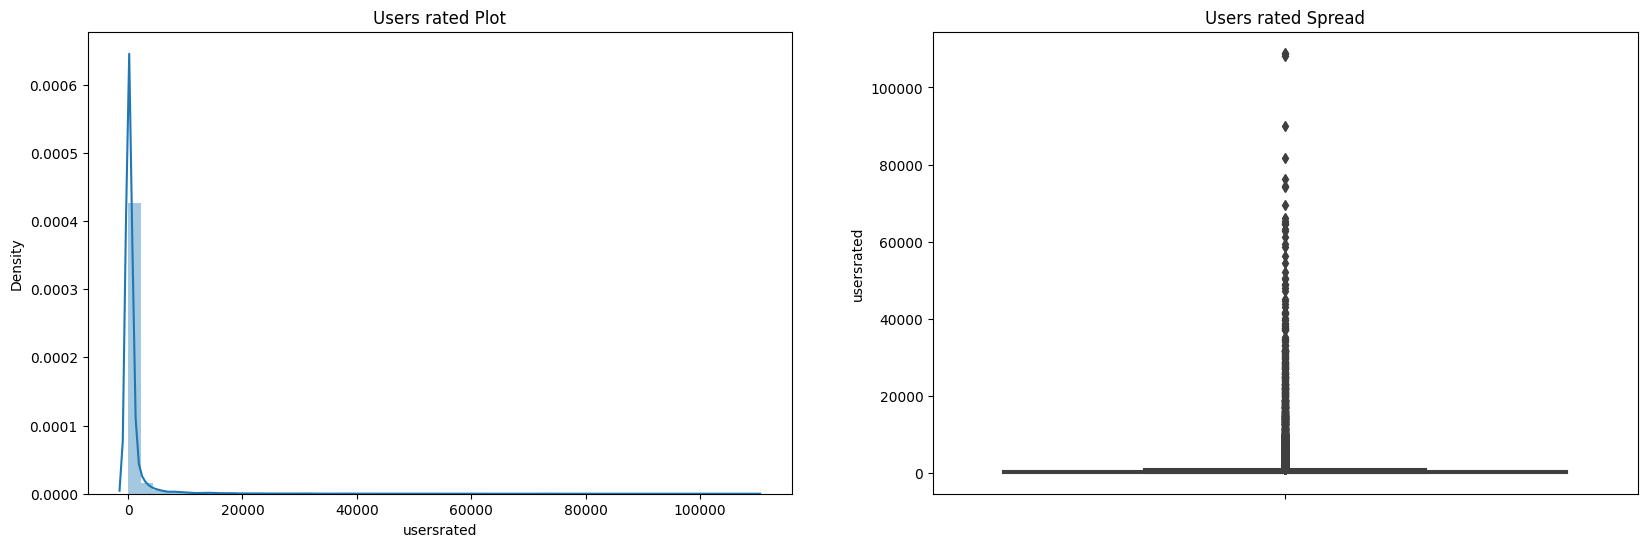

In [8]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.title('Users rated Plot')
sns.distplot(df_bg['usersrated'])

plt.subplot(1,2,2)
plt.title('Users rated Spread')
sns.boxplot(y=df_bg['usersrated'])

plt.show()

In [9]:
df_bg['usersrated'].describe([0.25, 0.5, 0.6, 0.7, 0.75, 0.8])

count     21631.000000
mean        875.000693
std        3697.681390
min          29.000000
25%          57.000000
50%         124.000000
60%         183.000000
70%         294.000000
75%         397.000000
80%         559.000000
max      109006.000000
Name: usersrated, dtype: float64

1. กราฟที่ได้เป็น Right skewed distributions
1.เกม 70% ที่มี `usersrated` ต่ำกว่า 300

ทำการตัดข้อมูลที่มี `usersrated` ต่ำกว่า 300

In [10]:
df_bg = df_bg[df_bg['usersrated'] >= 300]
df_bg['usersrated'].describe()

count      6405.000000
mean       2715.530523
std        6430.896016
min         300.000000
25%         478.000000
50%         857.000000
75%        2092.000000
max      109006.000000
Name: usersrated, dtype: float64

คัดเฉพาะเกมที่ `rank` ไม่เกิน 6000 (เกมที่แรงค์ต่ำเกินไปอาจเป็นเกมออกใหม่หรือไม่เป็นที่นิยม ซึ่งสามารถหาเล่นได้ยาก)

In [11]:
df_bg = df_bg[df_bg['rank'] != 'Not Ranked'] 
df_bg = df_bg.astype({'rank': int}, errors='raise')

df_bg = df_bg[df_bg['rank'] <= 6000].copy()
df_bg.shape

(5159, 20)

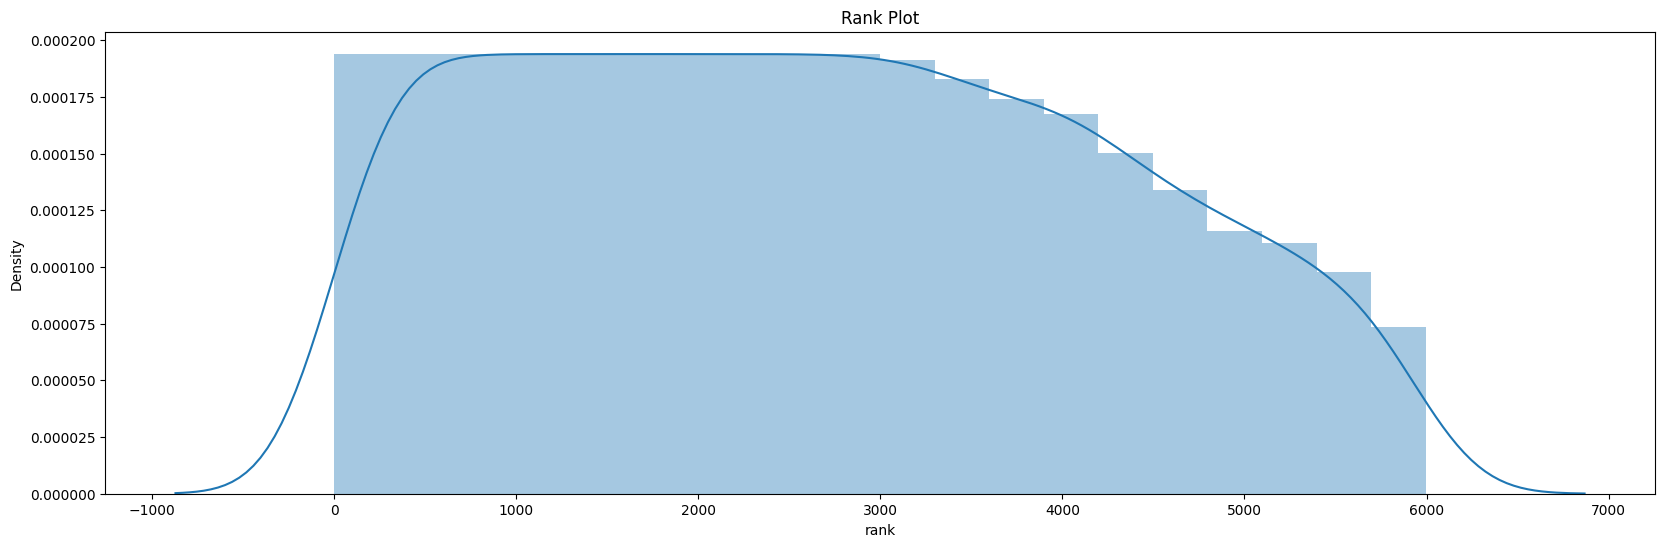

In [12]:
plt.figure(figsize=(20,6))
plt.title('Rank Plot')
sns.distplot(df_bg['rank'])
plt.show()

ข้อมูลที่ถูกตัดจาก`usersrated` มีเพียงเกมที่ `rank` มากกว่า 3000 เนื่องจากระบบ ranking ของ **BoardGameGeek** จัดตาม **Geek Rating** ซึ่งมีการใช้ dummy votes สำหรับเกมที่มีจำนวนคนให้คะแนนน้อย

ส่งผลให้เกมที่ได้คะแนนเยอะแต่มีจำนวนคนให้คะแนนน้อยมีแนวโน้มที่ **Geek Rating** น้อยกว่าเกมที่ได้คะแนนน้อยกว่าแต่มีจำนวนคนให้คะแนนเยอะ

ตัดข้อมูลที่ `category` หรือ `mechanic` เป็น null เนื่องจากไม่สามารถนำไปวิเคราะห์ได้

In [13]:
df_bg = df_bg[df_bg['category'] == df_bg['category']]
df_bg = df_bg[df_bg['mechanic'] == df_bg['mechanic']] 
df_bg.shape

(5036, 20)

แทนที่ `artist` และ `designer` ที่เป็น null ให้เป็น `unknown`

In [14]:
df_bg['artist'] = df_bg['artist'].fillna("'unknown'")
df_bg['designer'] = df_bg['designer'].fillna("'unknown'")

**Numerical Data**
* rank
* geek_rating
* avg_rating
* usersrated
* weight
* minplayers
* maxplayers
* playingtime
* minage
* owned
* yearpublished


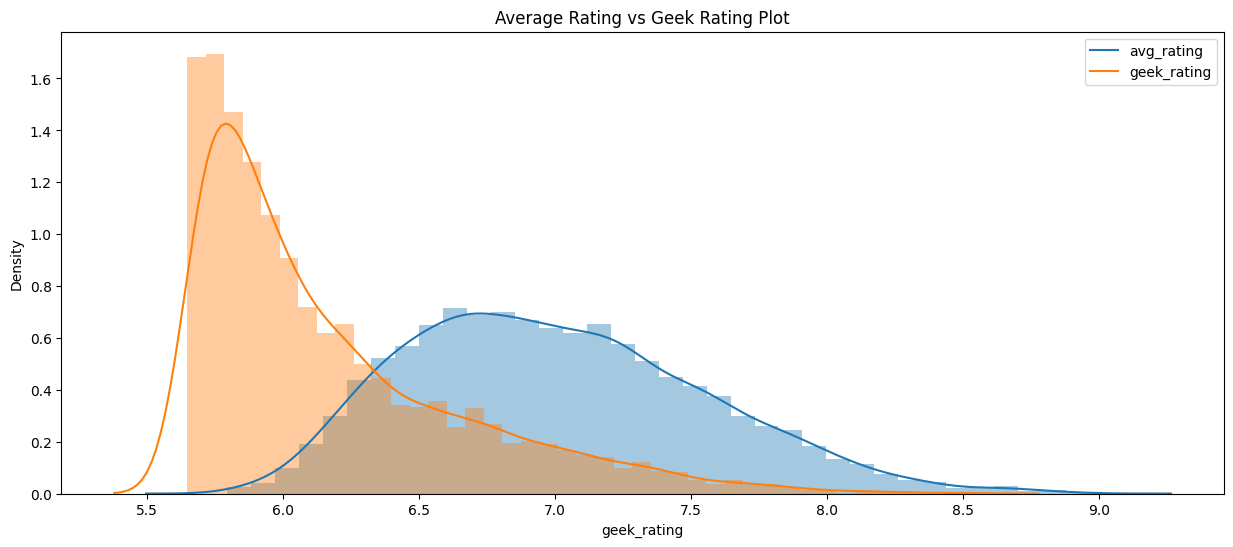

In [15]:
plt.figure(figsize=(15,6))
plt.title('Average Rating vs Geek Rating Plot')
sns.distplot(df_bg['avg_rating'])

sns.distplot(df_bg['geek_rating'])
plt.legend(['avg_rating', 'geek_rating'])
plt.show()

1. `avg_rating` เป็น normal distribution โดยมีค่าเฉลี่ยอยู่ที่ 7
1. `geek_rating` เป็น right skewed distribution เนื่องจากมีการดึงให้คะแนนอยู่ที่ 5.5

`avg_rating` มากกว่า `geek_rating`

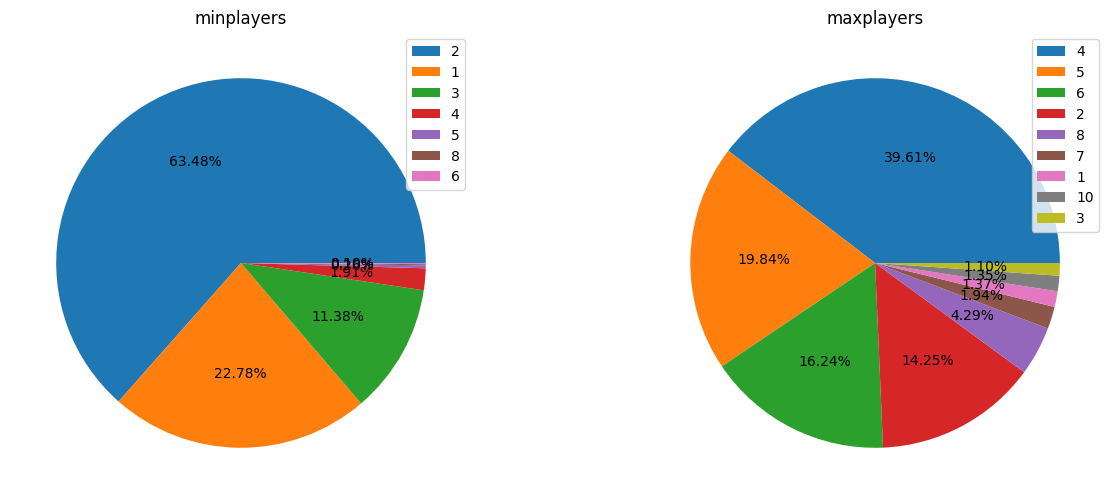

In [16]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('minplayers')
plt.pie(df_bg['minplayers'].value_counts(), autopct='%.2f%%')
plt.legend(df_bg['minplayers'].value_counts().index)

vc = df_bg['maxplayers'].value_counts()
vc = vc[vc > 50]
plt.subplot(1,2,2)
plt.title('maxplayers')
plt.pie(vc, autopct='%.2f%%')
plt.legend(vc.index)
plt.show()

1. เกมส่วนใหญ่ต้องมีผู้เล่น**อย่างน้อย 2 คน** (63.48%)
1. เกมส่วนใหญ่ออกแบบมาสำหรับเล่น **4 คน** (40.05%)
1. เกมที่**ออกแบบมาสำหรับเล่นคนเดียว**มีน้อยมาก (1.39%) แต่เนื่องจากบางเกมมีกฏพิเศษสำหรับการเล่นคนเดียวทำให้เกมที่**สามารถเล่นคนเดียวได้**มีมากพอสมควร (22.78%)

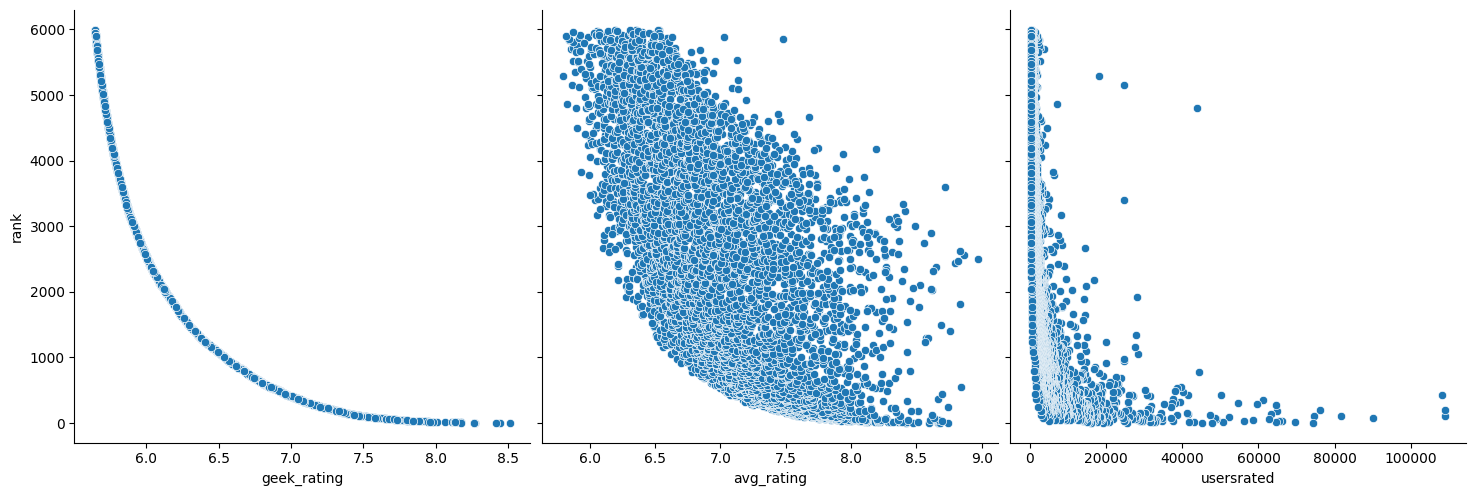

In [17]:
sns.pairplot(df_bg, x_vars=['geek_rating', 'avg_rating', 'usersrated'], y_vars='rank',size=5, aspect=1, kind='scatter')
plt.show()

1. `rank` จะแปรผกผันตาม `geek_rating`, `avg_rating` และ `usersrated`
1. `geek_rating` จะส่งผลต่อ `rank` โดยตรง

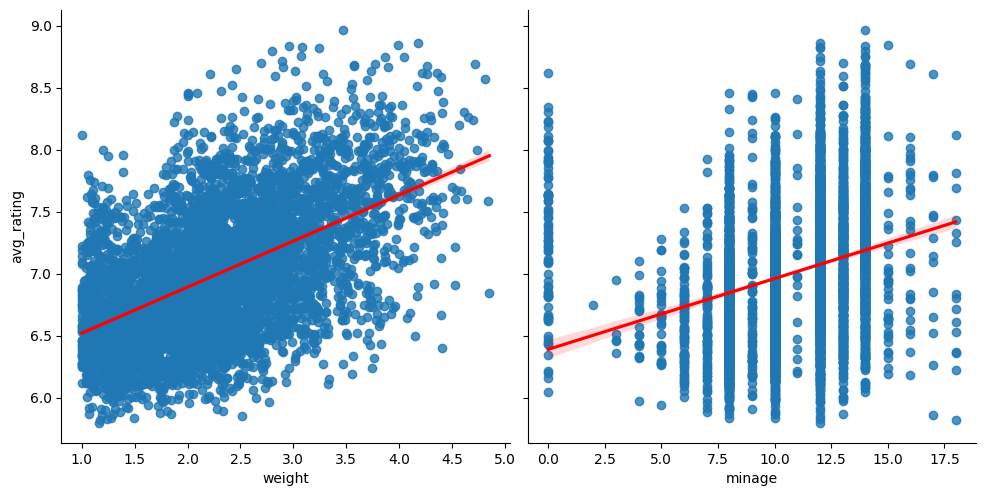

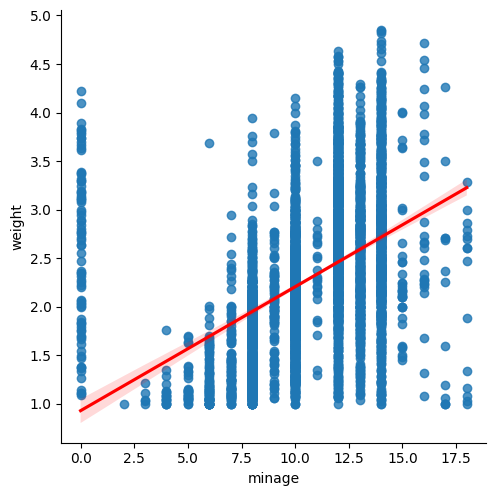

In [18]:
sns.pairplot(df_bg, x_vars=['weight','minage'], y_vars='avg_rating',size=5, aspect=1, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

sns.pairplot(df_bg, x_vars=['minage'], y_vars='weight',size=5, aspect=1, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

1. เกมที่**ยาก**จะมีแนวโน้มที่จะได้**คะแนนสูง**
1. เกมสำหรับผู้เล่นที่**อายุเยอะ**จะมีแนวโน้มที่จะได้**คะแนนสูง**
1. เกมที่**ยาก**จะออกแบบมาสำหรับผู้เล่นที่**อายุเยอะ**

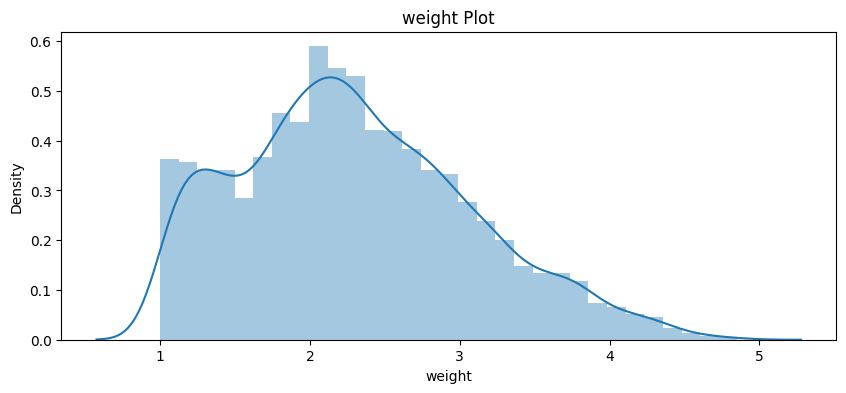

In [19]:
plt.figure(figsize=(10,4))
plt.title('weight Plot')
sns.distplot(df_bg['weight'])
plt.show()

เกมส่วนใหญ่มี `weight` อยู่ที่ 1.0 - 3.0

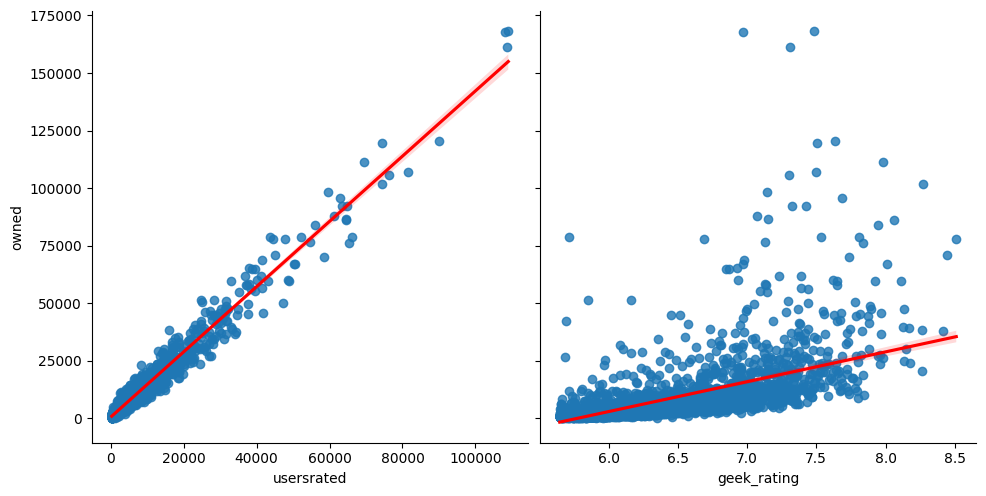

In [20]:
sns.pairplot(df_bg, x_vars=['usersrated', 'geek_rating'], y_vars='owned',size=5, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

เกมที่มี**คนเป็นเจ้าของ**เยอะจะมี**จำนวนคนให้คะแนน**เยอะ และมีแนวโน้มที่จะ**ได้คะแนน**มากขึ้นเล็กน้อย

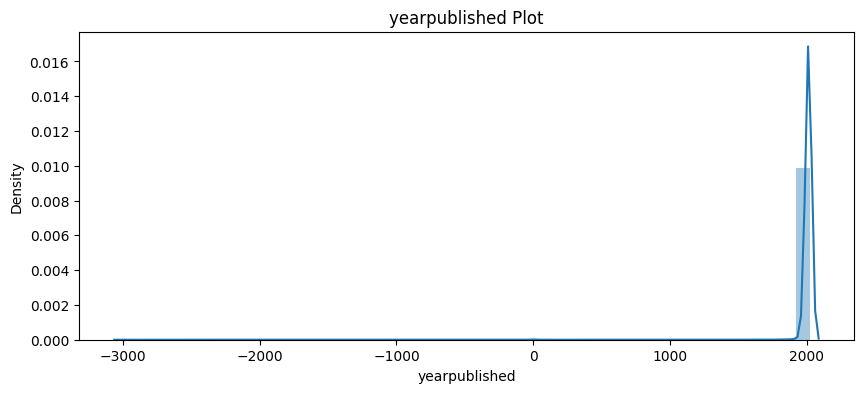

In [21]:
plt.figure(figsize=(10,4))
plt.title('yearpublished Plot')
sns.distplot(df_bg['yearpublished'])
plt.show()

In [22]:
old_game = df_bg.loc[df_bg['yearpublished']<=0]
old_game

,id,name,rank,geek_rating,avg_rating,usersrated,category,mechanic,weight,minplayers,maxplayers,playingtime,minage,owned,yearpublished,designer,artist,publisher,description,image
208,188,Go,186,7.31782,7.63588,15516,['Abstract Strategy'],"['Enclosure', 'Point to Point Movement', 'Squa...",3.9422,2,2,180,8,21439,-2200,['(Uncredited)'],"['(Uncredited)', 'Barbro Hennius', 'Norman Som...","['(Public Domain)', '(Self-Published)', '(Unkn...","By all appearances, it's just two players taki...",https://cf.geekdo-images.com/6qAiZwWxSSKP2kFcA...
296,2397,Backgammon,1332,6.36154,6.54443,12303,"['Abstract Strategy', 'Dice']","['Advantage Token', 'Betting and Bluffing', 'D...",2.0182,2,2,30,8,18889,-3000,['(Uncredited)'],"['(Uncredited)', 'Willem Cornelisz Duyster', '...","['(Public Domain)', '(Unknown)', '3M', 'ABRA',...",Backgammon is a classic abstract strategy game...,https://cf.geekdo-images.com/_6HVCuGni6NunlrSj...
1950,5072,Carrom,1580,6.26595,7.05447,1674,['Action / Dexterity'],"['Flicking', 'Team-Based Game']",1.4603,2,4,60,6,1873,0,['(Uncredited)'],'unknown',"['(Public Domain)', '(Unknown)', 'ABRA', 'ASS ...",Carrom is most easily described as &quot;finge...,https://cf.geekdo-images.com/vR9qsSxUGlmEydBU7...
2005,30618,Eat Poop You Cat,1147,6.45754,7.45018,1625,"['Humor', 'Party Game']",['Paper-and-Pencil'],1.1111,3,99,20,0,810,0,['(Uncredited)'],'unknown',['(Public Domain)'],Each player starts with a piece of paper and a...,https://cf.geekdo-images.com/XMkoh0Iwise1NlrwQ...
4954,11865,Koi-Koi,4828,5.71417,6.63866,455,['Card Game'],"['Hand Management', 'Push Your Luck', 'Set Col...",1.6875,2,4,30,0,447,0,['(Uncredited)'],'unknown',"['(Public Domain)', 'JuegosdeMesa.com.ar', 'Wa...",A traditional two-player Japanese card game pl...,https://cf.geekdo-images.com/JYZ21Y7RrYdCA9bo0...
5832,108018,Riichi Mahjong,3034,5.90997,8.32677,353,['Abstract Strategy'],"['Betting and Bluffing', 'Hand Management', 'S...",3.5000,4,4,120,8,389,0,['(Uncredited)'],'unknown',['(Public Domain)'],"Japanese Mahjong, especially called Riichi Mah...",https://cf.geekdo-images.com/62j0mEWiwuyZixScO...


เกมเหล่านี้ส่วนใหญ่เป็นเกมกระดานแบบดั้งเดิมที่ล้าสมัยซึ่งเราไม่ได้พยายามแนะนำเกมกระดานดังกล่าว จึงทำการกรองเกมก่อนปี **1995** ทิ้ง เนื่องจากเป็นปีที่ **Eurogames เกมแรกได้รับความนิยมนอกยุโรป**

In [23]:
df_bg = df_bg.loc[df_bg['yearpublished']>=1995]
df_bg.shape

(4609, 20)

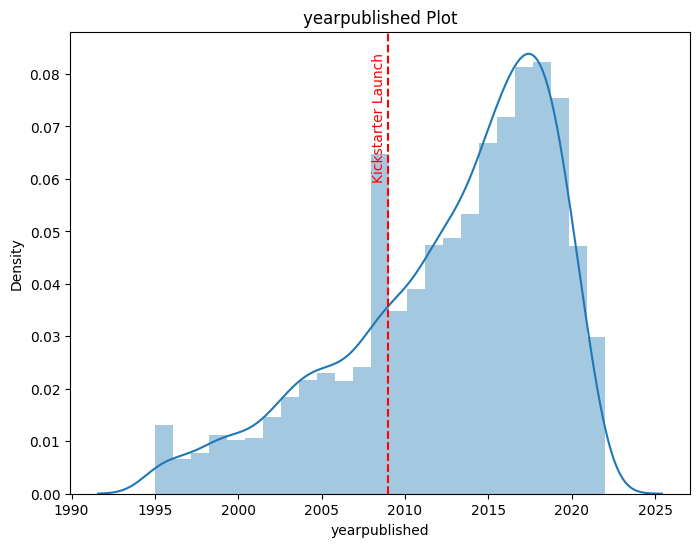

In [24]:
plt.figure(figsize=(8,6))
plt.title('yearpublished Plot')
sns.distplot(df_bg['yearpublished'])
plt.axvline(2009, ls='--', c='r')
plt.text(2008, 0.06, 'Kickstarter Launch', rotation='vertical', c='r');
plt.show()

อัตราการพัฒนาบอร์ดเกมสูงขึ้นเรื่อย ๆ โดยเฉพาะตั้งแต่ปี **2009** ซึ่งเป็นปีที่ **Kickstarter(บริษัทระดมทุน)เปิดตัว**

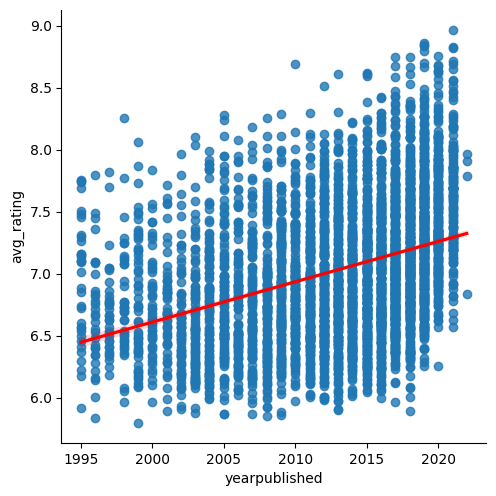

In [25]:
sns.pairplot(df_bg, x_vars='yearpublished', y_vars='avg_rating',size=5, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

ยิ่งเป็นเกมที่**ออกใหม่**จะมีแนวโน้มที่**ได้คะแนนสูง**ขึ้น (อาจเป็นเพราะจำนวนคนให้คะแนนน้อยทำให้เกิด bias)

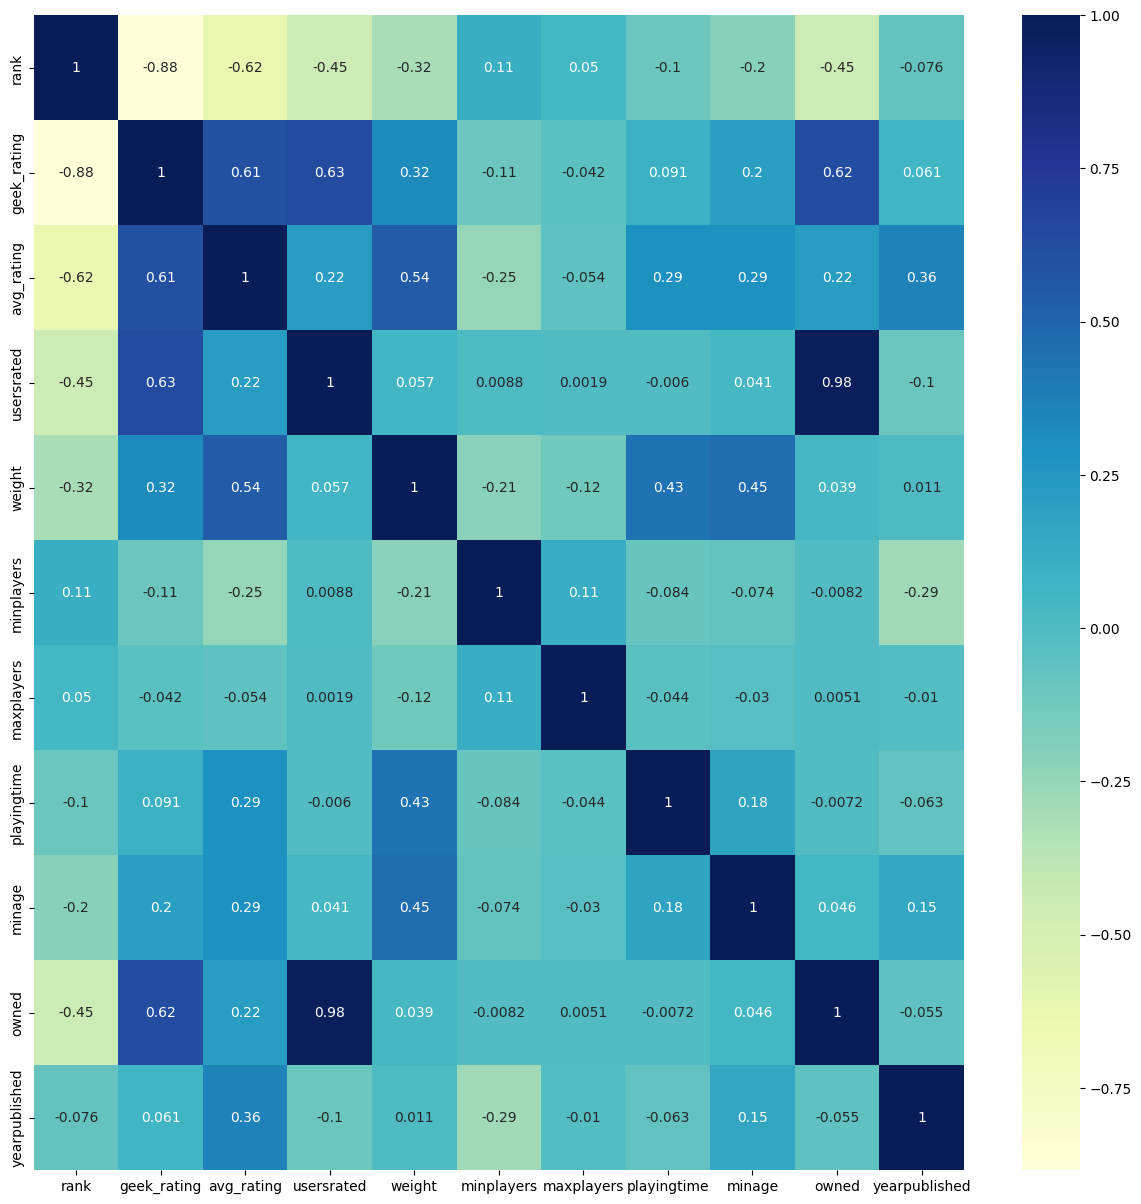

In [26]:
df_bg_num = df_bg[['rank', 'geek_rating', 'avg_rating', 'usersrated', 'weight', 'minplayers', 'maxplayers',
                   'playingtime', 'minage', 'owned' ,'yearpublished']].copy()

plt.figure(figsize = (15, 15))
sns.heatmap(df_bg_num.corr(), annot = True, cmap="YlGnBu")
plt.show()

1. `rank` ถูกจัดอันดับตาม `geek_rating`
1. `geek_rating` จะขึ้นอยู่กับ `avg_rating`, `usersrated` และ `weight`
1. เกมที่ `weight` สูงจะถูกออกแบบให้ `minage` เยอะและต้องใช้ `playingtime` เยอะ
1. `usersrated` และ `owned` มีความใกล้เคียงกันมากและสามารถใช้แทนกันได้ จึงตัด `owned` ทิ้ง
1. `yearpublished` ที่ใหม่จะมีแนวโน้มที่ได้ `avg_rating` สูง 

**Categorical Data**
* category 
* mechanic 
* designer
* artist
* publisher
* description

In [27]:
# df_bg_cat = df_bg[['category', 'mechanic']].copy()
df_bg['publisher'] = df_bg['publisher'].replace(', Ltd.','Ltd.', regex=True)
df_bg_cat = df_bg[['category', 'mechanic', 'designer', 'artist', 'publisher']].copy()


for col in df_bg_cat.columns:
    df_bg_cat[col] = df_bg_cat[col].apply(lambda x: x[1:len(x)-1].split(', '))

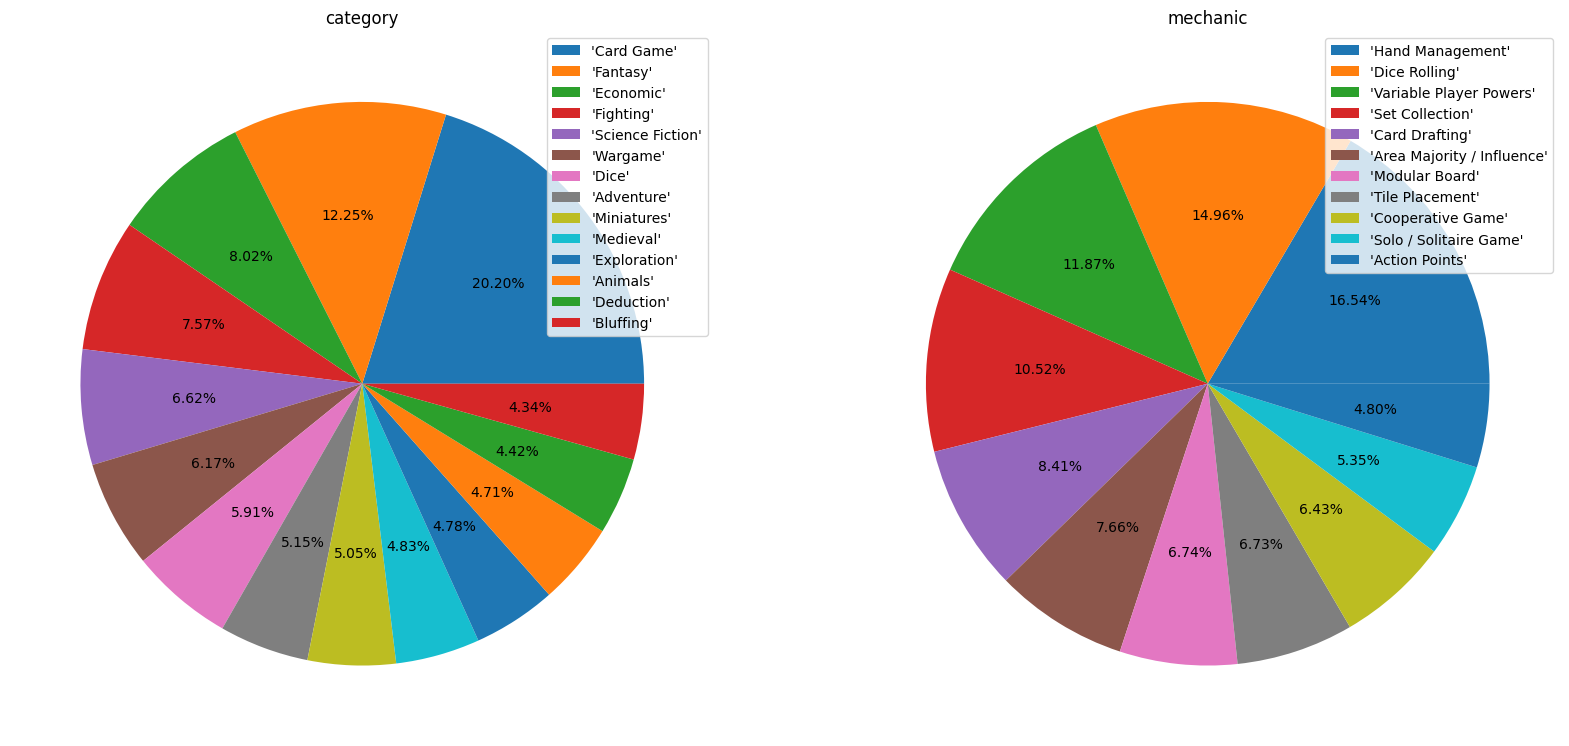

In [28]:
cat_counts = df_bg_cat.explode('category')
cat_vc = cat_counts.groupby("category").size().sort_values(ascending=False)
cat_vc = cat_vc[cat_vc > 300]

mech_counts = df_bg_cat.explode('mechanic')
mech_vc = mech_counts.groupby("mechanic").size().sort_values(ascending=False)
mech_vc = mech_vc[mech_vc > 430]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('category')
plt.pie(cat_vc, autopct='%.2f%%')
plt.legend(cat_vc.index)

plt.subplot(1,2,2)
plt.title('mechanic')
plt.pie(mech_vc, autopct='%.2f%%')
plt.legend(mech_vc.index)
plt.show()

1. `category` ที่พบมากที่สุดคือ `Card Game` และ `Fantasy`
1. `mechaic` ที่พบมากที่สุดคือ `Hand Management` และ `Dice Rolling`

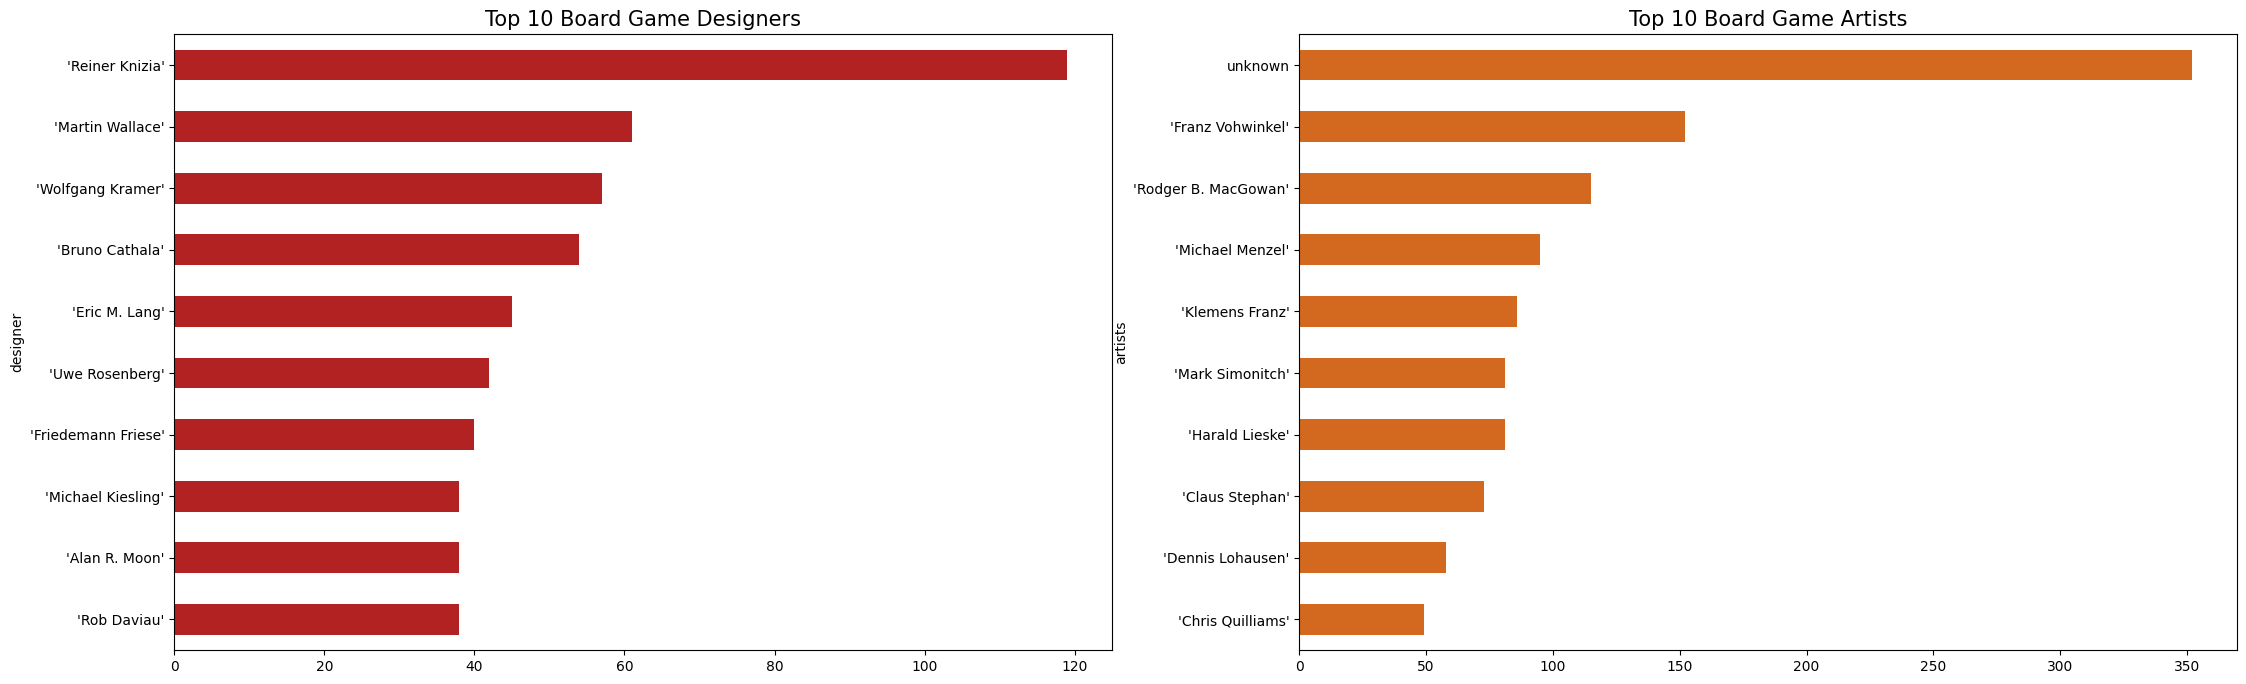

In [29]:
des_counts = df_bg_cat.explode('designer')
des_vc = des_counts.groupby('designer').size().sort_values(ascending=False)
des_vc = des_vc[des_vc > 35]

art_counts = df_bg_cat.explode('artist')
art_vc = art_counts.groupby('artist').size().sort_values(ascending=False)
art_vc = art_vc[art_vc > 47]

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.subplots_adjust(right=1.5)
des_vc.plot(kind='barh', color='firebrick')
plt.gca().invert_yaxis()
plt.title('Top 10 Board Game Designers', fontsize=15)
plt.ylabel('designer')

plt.subplot(1,2,2)
art_vc.plot(kind='barh', color='chocolate')
plt.gca().invert_yaxis()
plt.title('Top 10 Board Game Artists', fontsize=15)
plt.ylabel('artists')
plt.show()

`artist` มี `unknown` จำนวนมาก เนื่องจากเกมเหล่านี้อาจเป็นเกมของการผลิตขนาดเล็ก

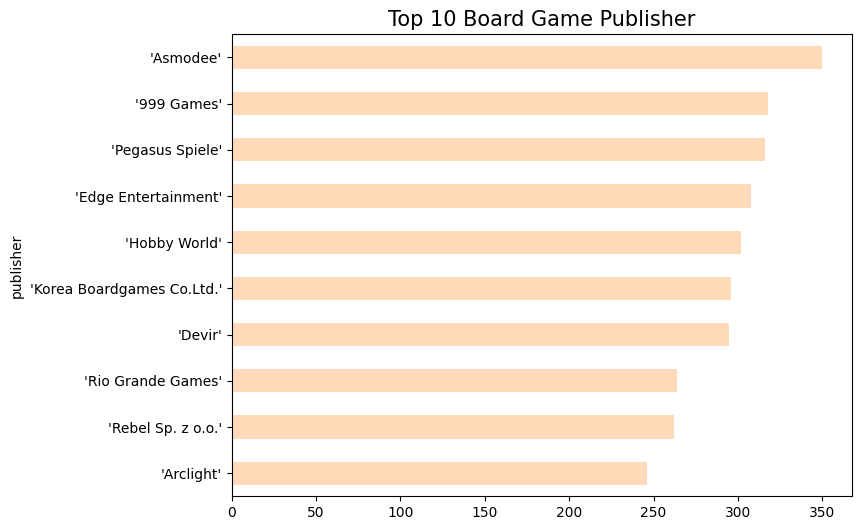

In [30]:
pub_counts = df_bg_cat.explode('publisher')
pub_vc = pub_counts.groupby('publisher').size().sort_values(ascending=False)
pub_vc = pub_vc[pub_vc > 240]

plt.figure(figsize=(8,6))
pub_vc.plot(kind='barh', color='peachpuff')
plt.gca().invert_yaxis()
plt.title('Top 10 Board Game Publisher', fontsize=15)
plt.ylabel('publisher')
plt.show()

`Asmodee` เผยแพร่เกมเป็นจำนวนมากที่สุด เนื่องจากเป็นหนึ่งในผู้เผยแพร่รายใหญ่ที่สุดและยังทำให้เกมกระดานหลายเกมเป็นแบบ digital ทำให้ชื่อเสียงของพวกเขาเพิ่มมากขึ้น

# Data Cleaning & EDA (Reviews)

In [31]:
df_rv = df_rv_tmp.copy()
df_rv.head()

,Unnamed: 0,user,rating,comment,ID,name
0,0,Torsten,10.0,NaN,30549,Pandemic
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
3,3,Mike Mayer,10.0,NaN,30549,Pandemic
4,4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic


In [32]:
df_rv.shape

(18964807, 6)

ตัดรีวิวที่ `name` ไม่ได้อยู่ใน `df_bg` 

In [33]:
df_rv = df_rv[df_rv['name'].isin(df_bg['name'])]
df_rv = df_rv[['user', 'name', 'rating', 'comment']]
df_rv.shape

(15281411, 4)

In [34]:
df_rv['rating'].describe()

count    1.528141e+07
mean     7.282578e+00
std      1.471673e+00
min      1.401300e-45
25%      6.500000e+00
50%      7.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

ตัดข้อมูลที่ `rating` น้อยกว่า 1

In [35]:
df_rv = df_rv[df_rv['rating']>=1]
df_rv['rating'].describe()

count    1.528141e+07
mean     7.282580e+00
std      1.471670e+00
min      1.000000e+00
25%      6.500000e+00
50%      7.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

ตัดข้อมูลที่ไม่มี `user`

In [36]:
df_rv = df_rv[df_rv['user'] == df_rv['user']]

ตัด `user` ที่มีการให้คะแนนน้อยกว่า 100 เกม

In [37]:
cv = df_rv['user'].value_counts()
df_rv = df_rv[df_rv['user'].isin(cv[cv >= 450].index)]
df_rv.shape

(2041970, 4)

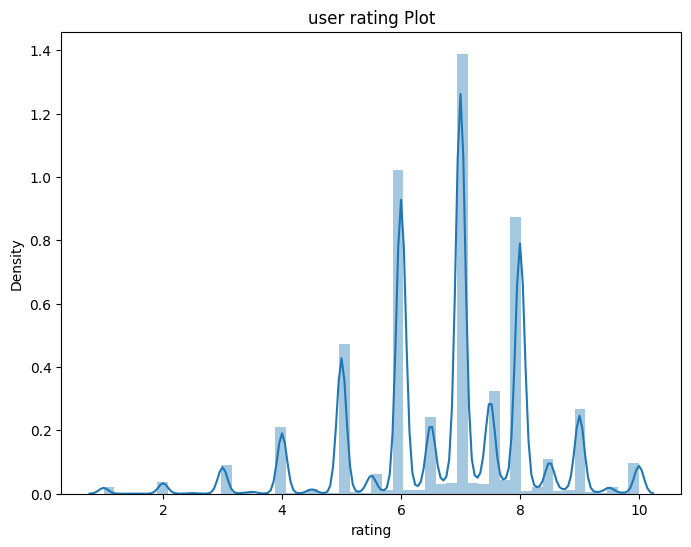

In [38]:
plt.figure(figsize=(8,6))
plt.title('user rating Plot')
sns.distplot(df_rv['rating'])
plt.show()

ผู้ใช้ส่วนใหญ่ให้ `rating` ที่ 6-8

In [39]:
not_comment = df_rv.isna().sum().sort_values(ascending=False)[0]

d = {"doesn't comment": not_comment, 'comment': df_rv.shape[0]-not_comment}    
ser_comment = pd.Series(data=d, index=["doesn't comment", 'comment'])
ser_comment

doesn't comment    1509499
comment             532471
dtype: int64

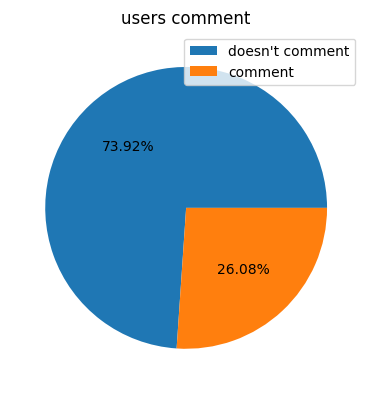

In [40]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title('users comment')
plt.pie(ser_comment, autopct='%.2f%%')
plt.legend(ser_comment.index)
plt.show()

มีผู้ใช้ที่ `comment` เพียง 26% จากรีวิวทั้งหมด (5 แสนคนจาก 2 ล้านคน)

# Save clean data to CSV

In [41]:
# df_bg.to_csv('games-cleaned.csv', index=False)
# df_rv.to_csv('reviews-cleaned.csv', index=False)